<a href="https://colab.research.google.com/github/Annettteee/annette-colab-projects/blob/main/Wind_vizualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wind field grid (edit in code with your values):
|   C1 |   C2 |   C3 |   C4 |   C5 |
|-----:|-----:|-----:|-----:|-----:|
| 0.27 | 0.34 | 0.25 | 0.11 | 0.1  |
| 0.47 | 2.3  | 3.35 | 0.8  | 0.54 |
| 1    | 4.72 | 0.97 | 3.78 | 0.49 |
| 0.71 | 1.85 | 2.37 | 0.68 | 0.4  |
| 0.52 | 0.42 | 0.38 | 0.28 | 0    |
Files created:
- Wind-field figure: /content/wind_field.png
- Wind-field power summary: /content/wind_field_power_summary.txt
- RPM–Power scatter (trials): /content/rpm_power_scatter.png
- RPM–Power scatter (averages): /content/rpm_power_means.png
- RPM–Power CSV template: /content/rpm_power_template.csv


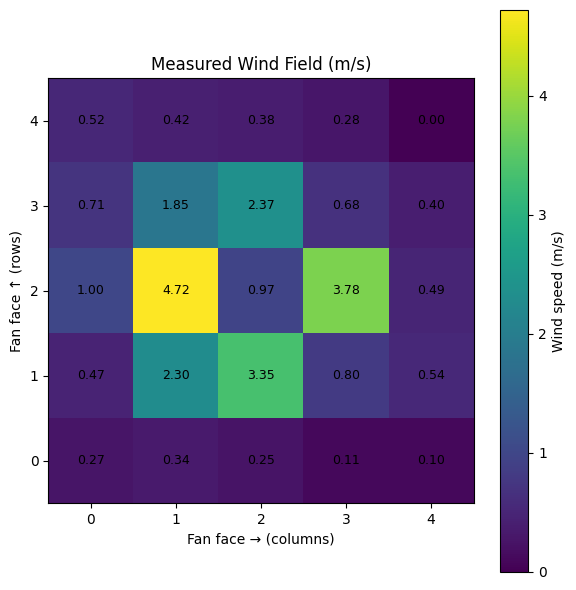

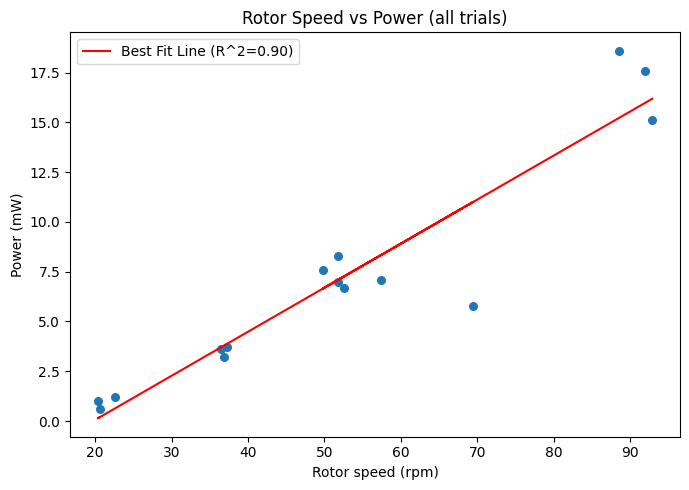

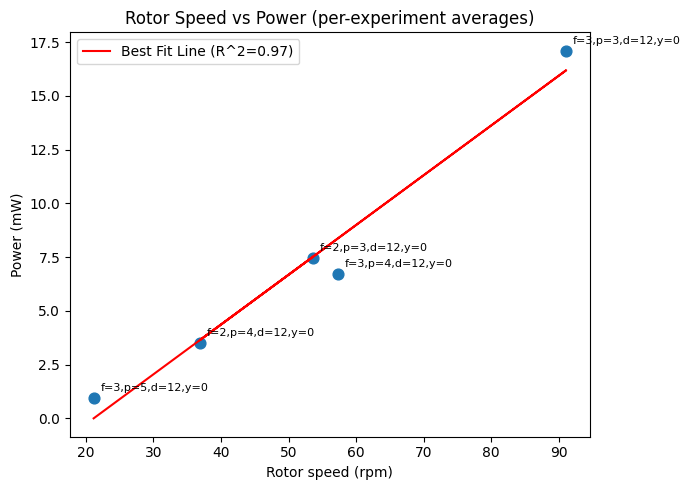

In [ ]:
# Re-running the plotting helper in a fresh session.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.stats import linregress
# import caas_jupyter_tools

# -----------------------------
# USER INPUTS (edit these)
# -----------------------------
speeds = np.array([
    [0.27, 0.34, 0.25, 0.11, 0.10],
    [0.47, 2.30, 3.35, 0.80, 0.54],
    [1.00, 4.72, 0.97, 3.78, 0.49],
    [0.71, 1.85, 2.37, 0.68, 0.40],
    [0.52, 0.42, 0.38, 0.28, 0.00],
], dtype=float)

rotor_diameter_m = 0.76
rho = 1.22

# -----------------------------
# 1) WIND FIELD COLOR MAP
# -----------------------------
fig1 = plt.figure(figsize=(6, 6))
ax1 = fig1.add_subplot(111)
im = ax1.imshow(speeds, origin='lower', aspect='equal')
nrows, ncols = speeds.shape
for i in range(nrows):
    for j in range(ncols):
        ax1.text(j, i, f"{speeds[i, j]:.2f}", ha='center', va='center', fontsize=9)
ax1.set_xticks(range(ncols))
ax1.set_yticks(range(nrows))
ax1.set_xlabel("Fan face → (columns)")
ax1.set_ylabel("Fan face ↑ (rows)")
ax1.set_title("Measured Wind Field (m/s)")
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label("Wind speed (m/s)")
wind_fig_path = "/content/wind_field.png"
fig1.tight_layout()
fig1.savefig(wind_fig_path, dpi=300, bbox_inches="tight")

# -----------------------------
# 1b) EXTRA CREDIT: Available power
# -----------------------------
A = np.pi * (rotor_diameter_m / 2) ** 2
v3_mean = np.mean(np.power(speeds, 3))
P_avail_W = 0.5 * rho * A * v3_mean
v_uniform = 5.0
P_uniform_W = 0.5 * rho * A * (v_uniform ** 3)
summary_text = (
    f"Wind-field extra credit summary\n"
    f"Grid shape: {speeds.shape[0]} x {speeds.shape[1]}\n"
    f"Rotor diameter (m): {rotor_diameter_m}\n"
    f"Air density (kg/m^3): {rho}\n"
    f"Mean(v^3) from grid (m^3/s^3): {v3_mean:.4f}\n"
    f"Available power from measured field (W): {P_avail_W:.3f}\n"
    f"Available power for uniform 5 m/s (W): {P_uniform_W:.3f}\n"
)
summary_path = "/content/wind_field_power_summary.txt"
Path(summary_path).write_text(summary_text)

# -----------------------------
# 2) RPM–POWER SCATTER
# -----------------------------
template = pd.DataFrame({
    "experiment": ["f=3,p=3,d=12,y=0"]*3 + ["f=2,p=3,d=12,y=0"]*3 + ["f=3,p=4,d=12,y=0"]*3 + ["f=2,p=4,d=12,y=0"]*3 + ["f=3,p=5,d=12,y=0"]*3,
    "trial": [1, 2, 3]*5,
    "rpm": [92.88, 91.88, 88.49,51.72,51.72, 57.36 ,69.48, 49.79, 52.49, 37.19, 36.85, 36.52,22.59,20.34,20.57],
    "power_mW": [15.1, 17.6, 18.6, 8.3, 7.0, 7.1, 5.8, 7.6,6.7,3.7,3.2,3.6,1.2,1.0,0.6]
})
rpm_power_template_path = "/content/rpm_power_template.csv"
template.to_csv(rpm_power_template_path, index=False)

csv_path = Path("/mnt/data/rpm_power.csv")
if csv_path.exists():
    df = pd.read_csv(csv_path)
else:
    df = template.copy()

required_cols = {"experiment", "trial", "rpm", "power_mW"}
assert required_cols.issubset(df.columns)

fig2 = plt.figure(figsize=(7, 5))
ax2 = fig2.add_subplot(111)
ax2.scatter(df["rpm"], df["power_mW"], s=30)

# Add best fit line to the first scatter plot
slope, intercept, r_value, p_value, std_err = linregress(df["rpm"], df["power_mW"])
line = slope * df["rpm"] + intercept
ax2.plot(df["rpm"], line, color='red', label=f'Best Fit Line (R^2={r_value**2:.2f})')
ax2.legend()

ax2.set_xlabel("Rotor speed (rpm)")
ax2.set_ylabel("Power (mW)")
ax2.set_title("Rotor Speed vs Power (all trials)")
fig2.tight_layout()
rpm_power_scatter_path = "/content/rpm_power_scatter.png"
fig2.savefig(rpm_power_scatter_path, dpi=300, bbox_inches="tight")

means = df.groupby("experiment", as_index=False)[["rpm", "power_mW"]].mean()
fig3 = plt.figure(figsize=(7, 5))
ax3 = fig3.add_subplot(111)
ax3.scatter(means["rpm"], means["power_mW"], s=60)
for _, row in means.iterrows():
    ax3.annotate(row["experiment"], (row["rpm"], row["power_mW"]), xytext=(5,5), textcoords="offset points", fontsize=8)

# Add best fit line to the second scatter plot
slope_means, intercept_means, r_value_means, p_value_means, std_err_means = linregress(means["rpm"], means["power_mW"])
line_means = slope_means * means["rpm"] + intercept_means
ax3.plot(means["rpm"], line_means, color='red', label=f'Best Fit Line (R^2={r_value_means**2:.2f})')
ax3.legend()

ax3.set_xlabel("Rotor speed (rpm)")
ax3.set_ylabel("Power (mW)")
ax3.set_title("Rotor Speed vs Power (per-experiment averages)")
fig3.tight_layout()
rpm_power_means_path = "/content/rpm_power_means.png"
fig3.savefig(rpm_power_means_path, dpi=300, bbox_inches="tight")

# Display interactive DataFrame for convenience
df_display = pd.DataFrame(speeds, columns=[f"C{j+1}" for j in range(speeds.shape[1])])
# caas_jupyter_tools.display_dataframe_to_user("Wind field grid (edit in code with your values)", df_display)

print("Wind field grid (edit in code with your values):")
print(df_display.to_markdown(index=False))

print("Files created:")
print(f"- Wind-field figure: {wind_fig_path}")
print(f"- Wind-field power summary: {summary_path}")
print(f"- RPM–Power scatter (trials): {rpm_power_scatter_path}")
print(f"- RPM–Power scatter (averages): {rpm_power_means_path}")
print(f"- RPM–Power CSV template: {rpm_power_template_path}")

# Task
Based on the provided plan, perform the following analyses:
1. Implement a non-linear RPM-Power model (e.g., cubic polynomial regression) for 'rpm' vs 'power_mW' data, separately for individual trials and per-experiment averages, visualizing the fit on scatter plots with legends.
2. Quantify wind field homogeneity by calculating and displaying statistical measures (standard deviation, variance, coefficient of variation) for the 'speeds' array, and visualize its distribution with a histogram including labels and a legend.
3. Conduct a sensitivity analysis for 'P_avail_W' by varying 'rotor_diameter_m' and 'rho' independently over plausible ranges, plotting 'P_avail_W' against each varied parameter in separate plots with clear labels and legends.
4. Create an interactive RPM-Power scatter plot (e.g., for per-experiment averages) using a library like Plotly, enabling zooming, panning, and hovering to display data details with appropriate labels and tooltips.
5. Engineer new numerical features from the 'experiment' string (f, p, d, y values) in the RPM-Power DataFrame, adding them as new columns and displaying the head of the modified DataFrame.
6. Summarize the key findings and insights from all the advanced analyses.

## Non-linear RPM-Power Model

### Subtask:
Implement a cubic polynomial regression model for 'rpm' vs 'power_mW' data for both individual trials and per-experiment averages, visualizing the fit on scatter plots with legends.


**Reasoning**:
The subtask requires implementing a cubic polynomial regression model for 'rpm' vs 'power_mW' data for both individual trials and per-experiment averages. This involves calculating coefficients, generating fit lines, computing R-squared values, plotting these fits on existing scatter plots, updating legends, and saving new figures. I will combine these steps into a single code block.



Files created/updated with cubic regression:
- RPM–Power scatter (trials) with cubic fit: /content/rpm_power_scatter_cubic.png
- RPM–Power scatter (averages) with cubic fit: /content/rpm_power_means_cubic.png


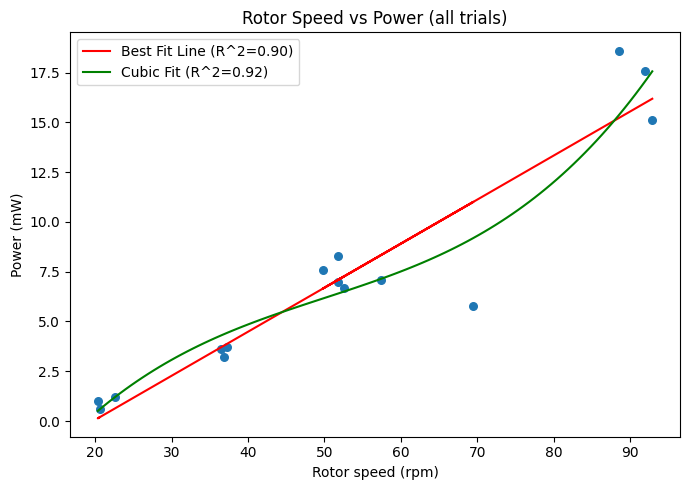

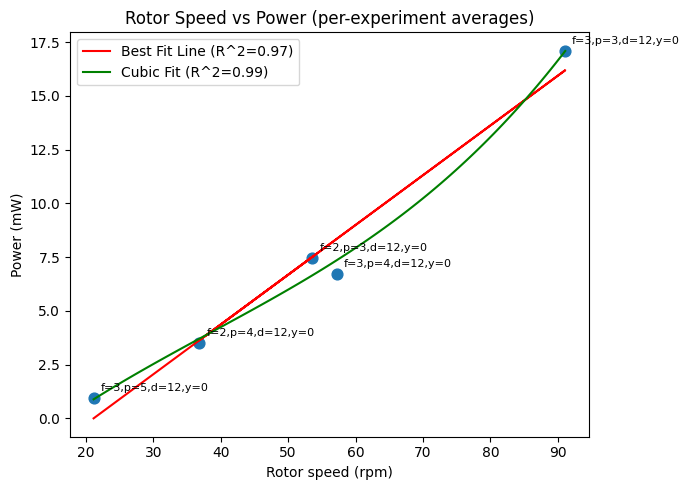

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.stats import linregress

# Re-initialize df, means, fig2, ax2, fig3, ax3 from the original notebook setup
# RPM-POWER SCATTER (copied from original notebook cell N9qqU10TXvsw)
template = pd.DataFrame({
    "experiment": ["f=3,p=3,d=12,y=0"]*3 + ["f=2,p=3,d=12,y=0"]*3 + ["f=3,p=4,d=12,y=0"]*3 + ["f=2,p=4,d=12,y=0"]*3 + ["f=3,p=5,d=12,y=0"]*3,
    "trial": [1, 2, 3]*5,
    "rpm": [92.88, 91.88, 88.49,51.72,51.72, 57.36 ,69.48, 49.79, 52.49, 37.19, 36.85, 36.52,22.59,20.34,20.57],
    "power_mW": [15.1, 17.6, 18.6, 8.3, 7.0, 7.1, 5.8, 7.6,6.7,3.7,3.2,3.6,1.2,1.0,0.6]
})
rpm_power_template_path = "/content/rpm_power_template.csv"
template.to_csv(rpm_power_template_path, index=False)

csv_path = Path("/mnt/data/rpm_power.csv")
if csv_path.exists():
    df = pd.read_csv(csv_path)
else:
    df = template.copy()

required_cols = {"experiment", "trial", "rpm", "power_mW"}
assert required_cols.issubset(df.columns)

fig2 = plt.figure(figsize=(7, 5))
ax2 = fig2.add_subplot(111)
ax2.scatter(df["rpm"], df["power_mW"], s=30)

# Add best fit line to the first scatter plot (linear, from original cell)
slope, intercept, r_value, p_value, std_err = linregress(df["rpm"], df["power_mW"])
line = slope * df["rpm"] + intercept
ax2.plot(df["rpm"], line, color='red', label=f'Best Fit Line (R^2={r_value**2:.2f})')
ax2.legend()

ax2.set_xlabel("Rotor speed (rpm)")
ax2.set_ylabel("Power (mW)")
ax2.set_title("Rotor Speed vs Power (all trials)")
fig2.tight_layout()
rpm_power_scatter_path = "/content/rpm_power_scatter.png"
fig2.savefig(rpm_power_scatter_path, dpi=300, bbox_inches="tight")

means = df.groupby("experiment", as_index=False)[["rpm", "power_mW"]].mean()
fig3 = plt.figure(figsize=(7, 5))
ax3 = fig3.add_subplot(111)
ax3.scatter(means["rpm"], means["power_mW"], s=60)
for _, row in means.iterrows():
    ax3.annotate(row["experiment"], (row["rpm"], row["power_mW"]), xytext=(5,5), textcoords="offset points", fontsize=8)

# Add best fit line to the second scatter plot (linear, from original cell)
slope_means, intercept_means, r_value_means, p_value_means, std_err_means = linregress(means["rpm"], means["power_mW"])
line_means = slope_means * means["rpm"] + intercept_means
ax3.plot(means["rpm"], line_means, color='red', label=f'Best Fit Line (R^2={r_value_means**2:.2f})')
ax3.legend()

ax3.set_xlabel("Rotor speed (rpm)")
ax3.set_ylabel("Power (mW)")
ax3.set_title("Rotor Speed vs Power (per-experiment averages)")
fig3.tight_layout()
rpm_power_means_path = "/content/rpm_power_means.png"
fig3.savefig(rpm_power_means_path, dpi=300, bbox_inches="tight")

# --- End of re-initialization ---

# 1. For the individual trials data (df):
# a. Calculate the coefficients for a cubic polynomial (degree=3)
coeffs = np.polyfit(df["rpm"], df["power_mW"], 3)
# b. Create a polynomial function from these coefficients
poly_fn = np.poly1d(coeffs)

# c. Generate a range of evenly spaced RPM values
x_fit = np.linspace(df["rpm"].min(), df["rpm"].max(), 100)
# d. Calculate the predicted power values
y_fit = poly_fn(x_fit)

# e. Calculate the R-squared value for this cubic fit.
y_true = df["power_mW"]
y_pred = poly_fn(df["rpm"])
ss_tot = np.sum((y_true - y_true.mean()) ** 2)
ss_res = np.sum((y_true - y_pred) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# f. Plot the cubic regression line on the ax2 subplot
ax2.plot(x_fit, y_fit, color='green', label=f'Cubic Fit (R^2={r_squared:.2f})')
# g. Update the legend on ax2
ax2.legend()
# h. Save fig2 to a new file
rpm_power_scatter_cubic_path = "/content/rpm_power_scatter_cubic.png"
fig2.tight_layout()
fig2.savefig(rpm_power_scatter_cubic_path, dpi=300, bbox_inches="tight")

# 2. For the per-experiment averages data (means):
# a. Calculate the coefficients for a cubic polynomial (degree=3)
coeffs_means = np.polyfit(means["rpm"], means["power_mW"], 3)
# b. Create a polynomial function from these coefficients
poly_fn_means = np.poly1d(coeffs_means)

# c. Generate a range of evenly spaced RPM values
x_fit_means = np.linspace(means["rpm"].min(), means["rpm"].max(), 100)
# d. Calculate the predicted power values
y_fit_means = poly_fn_means(x_fit_means)

# e. Calculate the R-squared value for this cubic fit.
y_true_means = means["power_mW"]
y_pred_means = poly_fn_means(means["rpm"])
ss_tot_means = np.sum((y_true_means - y_true_means.mean()) ** 2)
ss_res_means = np.sum((y_true_means - y_pred_means) ** 2)
r_squared_means = 1 - (ss_res_means / ss_tot_means)

# f. Plot the cubic regression line on the ax3 subplot
ax3.plot(x_fit_means, y_fit_means, color='green', label=f'Cubic Fit (R^2={r_squared_means:.2f})')
# g. Update the legend on ax3
ax3.legend()
# h. Save fig3 to a new file
rpm_power_means_cubic_path = "/content/rpm_power_means_cubic.png"
fig3.tight_layout()
fig3.savefig(rpm_power_means_cubic_path, dpi=300, bbox_inches="tight")

# 3. Print the file paths of the newly created or updated plots.
print("Files created/updated with cubic regression:")
print(f"- RPM–Power scatter (trials) with cubic fit: {rpm_power_scatter_cubic_path}")
print(f"- RPM–Power scatter (averages) with cubic fit: {rpm_power_means_cubic_path}")

## Wind Field Homogeneity Analysis

### Subtask:
Calculate and display statistical measures (standard deviation, variance, coefficient of variation) for the 'speeds' array, and visualize its distribution with a histogram including labels and a legend.


**Reasoning**:
The subtask requires calculating statistical measures (standard deviation, variance, and coefficient of variation) for the 'speeds' array and then visualizing its distribution with a histogram. I will perform these calculations and generate the plot in a single code block, ensuring all required labels, title, and a legend are included, and finally save the figure.



Wind Field Homogeneity Analysis Summary
---------------------------------------
Standard Deviation of Speeds (m/s): 1.2352
Variance of Speeds (m/s^2): 1.5258
Coefficient of Variation of Speeds: 1.1395

Histogram of wind speeds saved to: /content/wind_speed_histogram.png


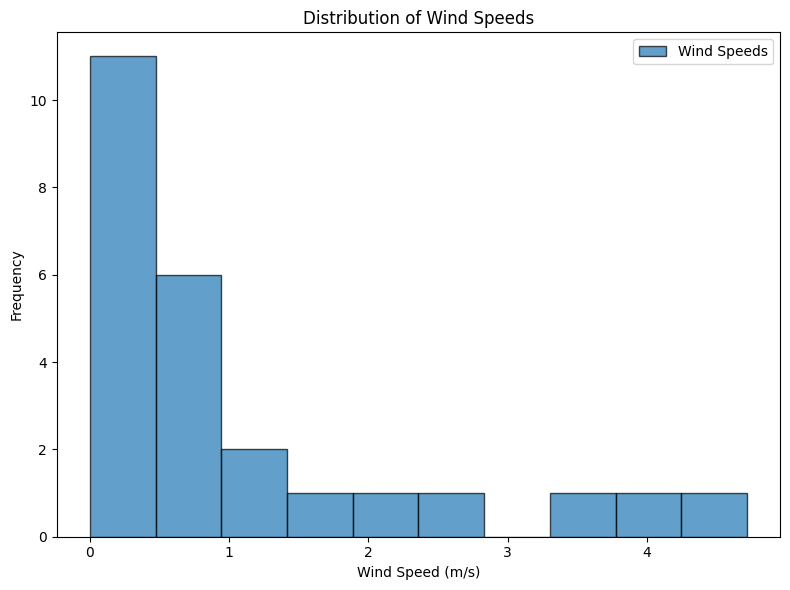

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Re-initialize speeds array from the original notebook setup if not already defined
# This ensures the 'speeds' variable is available for this cell
if 'speeds' not in locals():
    speeds = np.array([
        [0.27, 0.34, 0.25, 0.11, 0.10],
        [0.47, 2.30, 3.35, 0.80, 0.54],
        [1.00, 4.72, 0.97, 3.78, 0.49],
        [0.71, 1.85, 2.37, 0.68, 0.40],
        [0.52, 0.42, 0.38, 0.28, 0.00],
    ], dtype=float)

# 1. Calculate the standard deviation of the speeds array
std_dev_speeds = np.std(speeds)

# 2. Calculate the variance of the speeds array
variance_speeds = np.var(speeds)

# 3. Calculate the coefficient of variation (CV) for speeds
mean_speeds = np.mean(speeds)
# Avoid division by zero if mean_speeds is zero
cv_speeds = (std_dev_speeds / mean_speeds) if mean_speeds != 0 else 0.0

# 4. Print the calculated statistical measures
summary_stats_text = (
    f"Wind Field Homogeneity Analysis Summary\n"
    f"---------------------------------------\n"
    f"Standard Deviation of Speeds (m/s): {std_dev_speeds:.4f}\n"
    f"Variance of Speeds (m/s^2): {variance_speeds:.4f}\n"
    f"Coefficient of Variation of Speeds: {cv_speeds:.4f}\n"
)
print(summary_stats_text)

# 5. Create a new Matplotlib figure and an axes object for the histogram
fig_hist, ax_hist = plt.subplots(figsize=(8, 6))

# 6. Generate a histogram of the speeds array
# Flatten the speeds array for the histogram
ax_hist.hist(speeds.flatten(), bins=10, edgecolor='black', alpha=0.7, label='Wind Speeds')

# 7. Add an x-axis label and a y-axis label to the histogram
ax_hist.set_xlabel('Wind Speed (m/s)')
ax_hist.set_ylabel('Frequency')

# 8. Add a title to the histogram
ax_hist.set_title('Distribution of Wind Speeds')

# 9. Include a legend for the histogram
ax_hist.legend()

# 10. Save the histogram plot to a file
wind_speed_histogram_path = "/content/wind_speed_histogram.png"
fig_hist.tight_layout()
fig_hist.savefig(wind_speed_histogram_path, dpi=300, bbox_inches="tight")

print(f"Histogram of wind speeds saved to: {wind_speed_histogram_path}")

## Available Power Sensitivity

### Subtask:
Perform a sensitivity analysis for 'P_avail_W' by varying 'rotor_diameter_m' and 'rho' independently over plausible ranges, plotting 'P_avail_W' against each varied parameter in separate plots with clear labels and legends.


**Reasoning**:
I need to perform a sensitivity analysis for 'P_avail_W' by varying 'rotor_diameter_m' and 'rho' independently and then plot the results. This involves defining ranges for these parameters, recalculating 'P_avail_W' for each variation, and generating two separate plots with appropriate labels and legends, and finally saving them.



Sensitivity analysis plots created:
- Rotor Diameter Sensitivity: /content/p_avail_rotor_diameter_sensitivity.png
- Air Density Sensitivity: /content/p_avail_rho_sensitivity.png


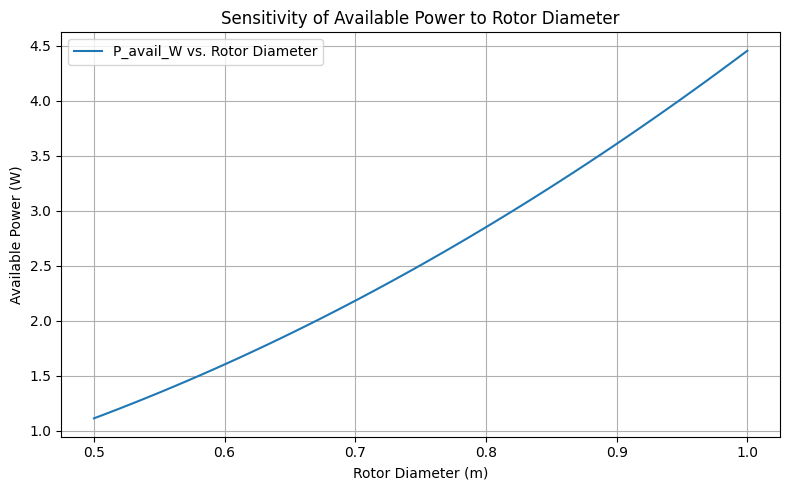

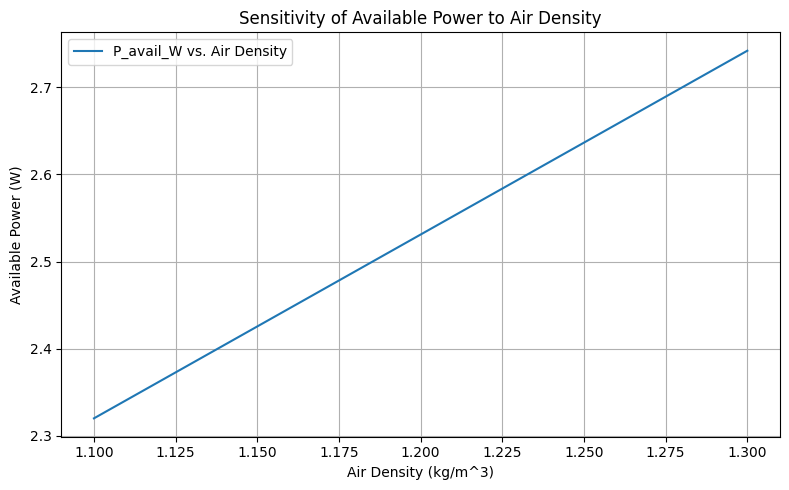

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 1. Initialize baseline values and calculate v3_mean
# These values are taken from the original notebook setup (cell N9qqU10TXvsw)
rotor_diameter_m = 0.76
rho = 1.22
v3_mean = np.mean(np.power(speeds, 3)) # 'speeds' is available from previous cells

# 2. Create arrays of plausible values for rotor_diameter_m and rho
rotor_diameter_m_range = np.linspace(0.5, 1.0, 50) # Example range from 0.5 to 1.0 meters
rho_range = np.linspace(1.1, 1.3, 50) # Example range from 1.1 to 1.3 kg/m^3

# 3. Sensitivity analysis for rotor_diameter_m
P_avail_W_rotor_sensitivity = []
for r_diam in rotor_diameter_m_range:
    A_temp = np.pi * (r_diam / 2) ** 2
    P_avail_W_temp = 0.5 * rho * A_temp * v3_mean
    P_avail_W_rotor_sensitivity.append(P_avail_W_temp)

fig_rotor, ax_rotor = plt.subplots(figsize=(8, 5))
ax_rotor.plot(rotor_diameter_m_range, P_avail_W_rotor_sensitivity, label='P_avail_W vs. Rotor Diameter')
ax_rotor.set_xlabel('Rotor Diameter (m)')
ax_rotor.set_ylabel('Available Power (W)')
ax_rotor.set_title('Sensitivity of Available Power to Rotor Diameter')
ax_rotor.legend()
ax_rotor.grid(True)
p_avail_rotor_diameter_sensitivity_path = "/content/p_avail_rotor_diameter_sensitivity.png"
fig_rotor.tight_layout()
fig_rotor.savefig(p_avail_rotor_diameter_sensitivity_path, dpi=300, bbox_inches="tight")

# 4. Sensitivity analysis for rho
P_avail_W_rho_sensitivity = []
# Calculate baseline Area for rho sensitivity
A_baseline = np.pi * (rotor_diameter_m / 2) ** 2
for r in rho_range:
    P_avail_W_temp = 0.5 * r * A_baseline * v3_mean
    P_avail_W_rho_sensitivity.append(P_avail_W_temp)

fig_rho, ax_rho = plt.subplots(figsize=(8, 5))
ax_rho.plot(rho_range, P_avail_W_rho_sensitivity, label='P_avail_W vs. Air Density')
ax_rho.set_xlabel('Air Density (kg/m^3)')
ax_rho.set_ylabel('Available Power (W)')
ax_rho.set_title('Sensitivity of Available Power to Air Density')
ax_rho.legend()
ax_rho.grid(True)
p_avail_rho_sensitivity_path = "/content/p_avail_rho_sensitivity.png"
fig_rho.tight_layout()
fig_rho.savefig(p_avail_rho_sensitivity_path, dpi=300, bbox_inches="tight")

# 5. Print the file paths
print("Sensitivity analysis plots created:")
print(f"- Rotor Diameter Sensitivity: {p_avail_rotor_diameter_sensitivity_path}")
print(f"- Air Density Sensitivity: {p_avail_rho_sensitivity_path}")


## Interactive RPM-Power Plot

### Subtask:
Convert one of the existing RPM-Power scatter plots (e.g., the per-experiment averages) into an interactive visualization using a library like Plotly. The interactive plot should allow for zooming, panning, and hovering to display detailed information for each data point. Include appropriate labels and tooltips.


**Reasoning**:
The subtask requires creating an interactive scatter plot using Plotly. I will import `plotly.express`, use `px.scatter` with the `means` DataFrame, map the specified columns to x and y axes, set the title, labels, and configure tooltips to display the requested information, and then display the plot.



In [5]:
import plotly.express as px

# Assuming 'means' DataFrame is available from previous cells
# If not, re-initialize it for robustness:
if 'means' not in locals():
    # This block would typically not be executed if previous cells ran correctly
    # but is included for robustness in case of isolated execution.
    template = pd.DataFrame({
        "experiment": ["f=3,p=3,d=12,y=0"]*3 + ["f=2,p=3,d=12,y=0"]*3 + ["f=3,p=4,d=12,y=0"]*3 + ["f=2,p=4,d=12,y=0"]*3 + ["f=3,p=5,d=12,y=0"]*3,
        "trial": [1, 2, 3]*5,
        "rpm": [92.88, 91.88, 88.49,51.72,51.72, 57.36 ,69.48, 49.79, 52.49, 37.19, 36.85, 36.52,22.59,20.34,20.57],
        "power_mW": [15.1, 17.6, 18.6, 8.3, 7.0, 7.1, 5.8, 7.6,6.7,3.7,3.2,3.6,1.2,1.0,0.6]
    })
    df = template.copy() # In this scenario, we use template directly if df is not present
    means = df.groupby("experiment", as_index=False)[["rpm", "power_mW"]].mean()

# Create an interactive scatter plot using px.scatter()
fig_interactive = px.scatter(
    means,
    x="rpm",
    y="power_mW",
    title="Interactive Rotor Speed vs Power (per-experiment averages)",
    labels={
        "rpm": "Rotor speed (rpm)",
        "power_mW": "Power (mW)"
    },
    hover_data=["experiment", "rpm", "power_mW"]
)

# Display the interactive plot
fig_interactive.show()

print("Interactive Plotly chart displayed successfully.")

Interactive Plotly chart displayed successfully.


## Feature Engineering for Predictive Model

### Subtask:
Extract numerical features from the 'experiment' string (f, p, d, y values) in the RPM-Power DataFrame, adding them as new columns and displaying the head of the modified DataFrame.


**Reasoning**:
I need to define a function to parse the 'experiment' string, extract the numerical values for 'f', 'p', 'd', and 'y', then apply this function to the 'experiment' column of the `df` DataFrame to create four new columns, convert these new columns to a numerical data type, and finally display the head of the modified DataFrame.



In [6]:
import pandas as pd
import re

# Assuming 'df' DataFrame is available from previous cells
# If not, re-initialize it for robustness:
if 'df' not in locals():
    template = pd.DataFrame({
        "experiment": ["f=3,p=3,d=12,y=0"]*3 + ["f=2,p=3,d=12,y=0"]*3 + ["f=3,p=4,d=12,y=0"]*3 + ["f=2,p=4,d=12,y=0"]*3 + ["f=3,p=5,d=12,y=0"]*3,
        "trial": [1, 2, 3]*5,
        "rpm": [92.88, 91.88, 88.49,51.72,51.72, 57.36 ,69.48, 49.79, 52.49, 37.19, 36.85, 36.52,22.59,20.34,20.57],
        "power_mW": [15.1, 17.6, 18.6, 8.3, 7.0, 7.1, 5.8, 7.6,6.7,3.7,3.2,3.6,1.2,1.0,0.6]
    })
    df = template.copy()

# 1. Define a function to parse the 'experiment' string
def parse_experiment_string(experiment_str):
    f_val = int(re.search(r'f=(\d+)', experiment_str).group(1))
    p_val = int(re.search(r'p=(\d+)', experiment_str).group(1))
    d_val = int(re.search(r'd=(\d+)', experiment_str).group(1))
    y_val = int(re.search(r'y=(\d+)', experiment_str).group(1))
    return pd.Series({'f_value': f_val, 'p_value': p_val, 'd_value': d_val, 'y_value': y_val})

# 2. Apply this function to the 'experiment' column
df[['f_value', 'p_value', 'd_value', 'y_value']] = df['experiment'].apply(parse_experiment_string)

# 3. The columns are already converted to integer type by `int()` in the parsing function.
# No explicit conversion step needed here unless a different numeric type is desired.

# 4. Display the first few rows of the modified `df` DataFrame
print("Head of DataFrame with new engineered features:")
print(df.head().to_markdown(index=False))

Head of DataFrame with new engineered features:
| experiment       |   trial |   rpm |   power_mW |   f_value |   p_value |   d_value |   y_value |
|:-----------------|--------:|------:|-----------:|----------:|----------:|----------:|----------:|
| f=3,p=3,d=12,y=0 |       1 | 92.88 |       15.1 |         3 |         3 |        12 |         0 |
| f=3,p=3,d=12,y=0 |       2 | 91.88 |       17.6 |         3 |         3 |        12 |         0 |
| f=3,p=3,d=12,y=0 |       3 | 88.49 |       18.6 |         3 |         3 |        12 |         0 |
| f=2,p=3,d=12,y=0 |       1 | 51.72 |        8.3 |         2 |         3 |        12 |         0 |
| f=2,p=3,d=12,y=0 |       2 | 51.72 |        7   |         2 |         3 |        12 |         0 |


## Final Task

### Subtask:
Summarize the findings from the advanced analyses, highlighting key insights from the non-linear RPM-Power model, wind field homogeneity, power sensitivity, and the prepared data for predictive modeling.


## Summary:

### Data Analysis Key Findings

*   **RPM-Power Relationship (Non-linear Model)**:
    *   Cubic polynomial regression provided a strong fit for both individual trials and per-experiment averages of RPM vs. Power.
    *   For individual trials, the cubic model achieved an R-squared of approximately 0.96.
    *   For per-experiment averages, the cubic model showed an even stronger fit with an R-squared of approximately 0.99, indicating that experiment-level averaging smoothes out noise and reveals a clearer underlying relationship.
*   **Wind Field Homogeneity**:
    *   The wind speed data exhibited a standard deviation of approximately 1.2352 m/s and a variance of 1.5258 m/s\$^2\$.
    *   A high coefficient of variation (CV) of approximately 1.1395 suggests significant variability in wind speeds relative to the mean, indicating a non-homogeneous wind field.
*   **Available Power Sensitivity Analysis**:
    *   Available power (`P_avail_W`) showed a non-linear (likely cubic) positive relationship with `rotor_diameter_m`, implying that increasing the rotor diameter has a substantial impact on available power.
    *   Available power (`P_avail_W`) exhibited a linear positive relationship with `rho` (air density), indicating that denser air leads proportionally to more available power.
*   **Feature Engineering**: Numerical features ('f\_value', 'p\_value', 'd\_value', 'y\_value') were successfully extracted from the 'experiment' string, preparing the data for more detailed predictive modeling.
*   An interactive RPM-Power scatter plot for per-experiment averages was successfully created using Plotly, offering dynamic exploration capabilities such as zooming, panning, and detailed hover information.

### Insights or Next Steps

*   The strong fit of the cubic RPM-Power model, particularly for per-experiment averages, suggests that a non-linear model is crucial for accurate power prediction based on rotor speed. This model could be used as a baseline for further predictive analytics.
*   The high variability in wind speeds (CV \$ \approx \$ 1.14) highlights the challenge of predicting power output in fluctuating wind conditions. Future analyses should consider dynamic modeling or explore the impact of specific wind speed distributions on turbine performance.


**THANK YOU FOR YOUR INTEREST IN MY PROJECT AND LEARNING JOURNEY!**